In [1]:
import glob
from os import listdir
from os.path import isfile, join
import os.path as osp
import copy
import os
import pickle
from datetime import datetime
import random
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv
from torch_geometric.nn import GATv2Conv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def nextplot(force=False):
    """Start a new plot.

    In a notebook (or if `force=True`), create a new figure. Otherwise (e.g, in
    IPython), clear the current figure.

    """
    inNotebook = "IPKernelApp" in get_ipython().config
    if force or inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()  # and this clears the current one

In [3]:
class SkinbaronDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super(SkinbaronDataset, self).__init__(root, transform, pre_transform, pre_filter)
    @property
    def processed_file_names(self):
        return processed_graphs
    def len(self):
        return len(self.processed_file_names)
    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [4]:
class GATL1withSelf(nn.Module):
    """Define GATL1withSelf class for the Graph Attention neural network.(GAT)
    with one layer, and self loops"""

    def __init__(self, size_in, size_out, edge_size, num_head, tmax, dropout_prob):
        super(GATL1withSelf, self).__init__()
        self.conv1 = GATv2Conv(in_channels=size_in, out_channels=size_out, heads=num_head, edge_dim=edge_size,
                               dropout=dropout_prob, fill_value='mean')
        self.readout = nn.Linear(2 * num_head * size_out, tmax - 1)

    def forward(self, graph):
        graph.x = F.elu(self.conv1(graph.x, graph.edge_index, graph.edge_attr))
        s_t_nodes = torch.cat((graph.x[int(graph.edge_index[0, 0])], graph.x[int(graph.edge_index[1, 0])]))
        m_array_pred = torch.sigmoid(self.readout(s_t_nodes))
        for i in range(1, graph.edge_index.shape[1]):  # iterate over the number of edges in the batch (called graph)
            s_t_nodes = torch.cat((graph.x[int(graph.edge_index[0, i])], graph.x[int(graph.edge_index[1, i])]))
            edge_label_pred = torch.sigmoid(self.readout(s_t_nodes))
            m_array_pred = torch.cat((m_array_pred, edge_label_pred), 0)
        m_array_pred = m_array_pred.view(-1, tmax - 1)
        return m_array_pred

In [5]:
def getListofallkeys(dict):      
    return list(dict.keys())

In [6]:
# Get meta date from the event log
def logStatistics (event_log, main_label):
    # set required variables
    categorical_value_list = []
    cardinality_list = []
    cat_encoder_list = []
    max_len = 0
    # get length of the longest case in the log
    num_cases = len(event_log)
    for i in range (num_cases):
        current_length = len(event_log[i])
        max_len = max(max_len, current_length)
    # get list of all categorical attributes in the log    
    categorical_attributes = list(event_log[0][0].keys())    
    categorical_attributes.remove('case_id')
    # move the main label to the beginning of the list, if it is not already there.
    if categorical_attributes[0] != main_label:
        categorical_attributes.insert(0, categorical_attributes.pop(categorical_attributes.index(main_label)))      
    # get list of all possible values for main label in the log
    main_dict = attributes_filter.get_attribute_values(event_log, categorical_attributes[0])
    main_values = list(main_dict.keys())
    # one-hot encoding for main category labels
    main_array = np.array(main_values)
    main_enc = OneHotEncoder(handle_unknown='ignore')
    main_enc.fit(main_array.reshape(-1, 1))
    # remove the first element (aka main label) from the list
    categorical_attributes.pop(0)
    # get list of values, and cardinality of each of categorical attributes.
    for category in categorical_attributes:
        current_cat_dict = attributes_filter.get_attribute_values(event_log, category)
        current_cat_list = list(current_cat_dict.keys())
        categorical_value_list.append(current_cat_list)
        cardinality_list.append(len(current_cat_list))
        # one-hot encoding for each of categorical attribute
        current_array = np.array(current_cat_list)
        current_enc = OneHotEncoder(handle_unknown='ignore')
        current_enc.fit(current_array.reshape(-1, 1))
        cat_encoder_list.append(current_enc)
    return num_cases, max_len, main_array, main_enc, categorical_attributes, cardinality_list, cat_encoder_list

In [7]:
# method for creating node feature matrix for one trace, additionally we create a m_array dict, and pair_dict!
def build_node_feature_matrix(current_trace, main_label_array, main_encoder, max_trace_length, main_label):
    # Compute length of trace
    trace_length = len(current_trace)
    # dimensions of one-hot encoder for the main label:a dim*dim array:
    dim = len(main_label_array)
    """ initialize a dictionary to collect:
        Keys: tuple of main category labels (directly-followed pairs) 
        values: position of pair's occurrence in the trace
    """
    pair_dict = {}
    # initialize an auxiliary list to collect to collect unique activity labels in the current case
    main_list = []
    """ initialize a dictionary to collect:
        Keys: tuple of source node index, and target node index
        values: relevant m-array
    """
    m_array_dict = {}
    # creating pair_dict dictionary
    for i in range(trace_length - 1):
        current_main_label = current_trace[i].get(main_label)
        main_list.append(current_main_label)
        next_main_label = current_trace[i + 1].get(main_label)
        main_list.append(next_main_label)
        main_tuple = (current_main_label, next_main_label)
        if main_tuple in pair_dict:
            pair_dict[main_tuple].append(i)
        else:
            pair_dict[main_tuple] = [i]
    # identify unique activity labels, and initialize node feature matrix based on its size.
    main_set = list(set(main_list))
    node_feature = np.zeros((len(main_set), dim), dtype=np.float32)
    # create node feature matrix based on one-hot encoding
    counter_main = 0
    for main in main_set:
        main_arr = np.array(main)
        node_feature[counter_main] = main_encoder.transform(main_arr.reshape(-1, 1)).toarray()
        counter_main += 1
    # iterate over all directly-followed pairs, identify their source and target index in the node set.
    # create m-array based on the position(s) of their occurrence, and return indexes, and array in a dictionary
    for key in pair_dict:
        source_index = main_set.index(key[0])
        target_index = main_set.index(key[1])
        m_array = np.zeros(max_trace_length - 1, dtype=np.intc)
        for i in range(len(pair_dict[key])):
            m_array[pair_dict[key][i]] = 1
        m_array_dict[(source_index, target_index)] = m_array
    return pair_dict, node_feature, m_array_dict, main_set

In [8]:
# method for creating p_array dict, its structure is similar to the structure of m_array dict!
def build_p_array_dict(current_trace, m_array, pairs, main_set, max_trace_length, categorical, cardinality, cat_encoder_list):
    p_array_dict = {}
    m_size = sum(cardinality) # no need for extra dimension for timestamp as well as binary, numerical, ordinal atts
    for key in m_array:
        p_array = np.zeros((max_trace_length - 1) * m_size, dtype=np.float32) # seven for case attributes
        source_index = key[0]
        target_index = key[1]
        source_main = main_set[source_index]
        target_main = main_set[target_index]
        main_tuple = (source_main, target_main)
        current_occurrence = pairs[main_tuple]  # is a list
        for i in current_occurrence:
            # get the changes for categorical attributes
            pointer = 0
            iterator = 0
            for j in categorical:
                curr_card = cardinality[iterator]
                source_att = current_trace[i].get(j)
                target_att = current_trace[i + 1].get(j)
                if str(target_att) != 'nan':
                    curr_arr = np.array(target_att)
                    target_onehot = cat_encoder_list[iterator].transform(curr_arr.reshape(-1, 1)).toarray()
                    if str(source_att) == 'nan':
                        p_array[i * m_size + pointer: i * m_size + pointer + curr_card] = target_onehot
                    else:
                        if target_att != source_att:
                            curr_arr2 = np.array(source_att)
                            source_onehot = cat_encoder_list[iterator].transform(curr_arr2.reshape(-1, 1)).toarray()
                            p_array[i * m_size + pointer: i * m_size + pointer + curr_card] = target_onehot - source_onehot
                iterator = iterator + 1
                pointer = pointer + curr_card
                # now that we have the value (p_array), we link it to the current key in our dictionary
        p_array_dict[key] = p_array
    return p_array_dict

In [12]:
# Get all categorical attributes in an log + activity label (concept:name) 
def getcategorical(event_log):
    # get list of all categorical attributes in the log    
    categorical_attributes = list(event_log[0][0].keys())    
    categorical_attributes.remove('case_id')    
    return categorical_attributes

In [20]:
interest_path = r'D:\Final master thesis evaluation\exp3'
log_pattern = r'D:\Final master thesis evaluation\exp3\*.xes'
processed_path = [r'D:\Final master thesis evaluation\exp3\data\processed', 
                  r'D:\Final master thesis evaluation\exp4\data\processed',
                  r'D:\Final master thesis evaluation\exp5\data\processed',
                  r'D:\Final master thesis evaluation\exp6\data\processed']         
processed_Pattern = [r"D:\Final master thesis evaluation\exp3\data\processed\*.pt",
                     r"D:\Final master thesis evaluation\exp4\data\processed\*.pt",
                     r"D:\Final master thesis evaluation\exp5\data\processed\*.pt",
                     r"D:\Final master thesis evaluation\exp6\data\processed\*.pt"]
targat_path = [r"D:\Final master thesis evaluation\exp3\data", 
               r"D:\Final master thesis evaluation\exp4\data",
               r"D:\Final master thesis evaluation\exp5\data",
               r"D:\Final master thesis evaluation\exp6\data"]
logs = glob.glob(log_pattern)

In [10]:
for log in logs:
    name_hint = os.path.basename(log)
    name_hint = name_hint.replace('0.', '')
    name_hint = name_hint.replace('.xes', '')
print(name_hint)

large-1-1


In [13]:
# import the log
event_log = xes_importer.apply(logs[0])

parsing log, completed traces ::   0%|          | 0/15000 [00:00<?, ?it/s]

In [21]:
all_attributes = getcategorical (event_log)
# remove the first element (aka main label) from the list
all_attributes.pop(0)
print(all_attributes)

['user', 'day', 'country', 'company']


In [34]:
category_counter = 0
for category in all_attributes:
    if category_counter == 0:
        case_id_target = r"D:\Final master thesis evaluation\exp3\case_id_list.pkl"
    elif category_counter == 1:
        case_id_target = r"D:\Final master thesis evaluation\exp4\case_id_list.pkl"
    elif category_counter == 2: 
        case_id_target = r"D:\Final master thesis evaluation\exp5\case_id_list.pkl"
    elif category_counter == 3: 
        case_id_target = r"D:\Final master thesis evaluation\exp6\case_id_list.pkl"
    # get required meta data
    num_cases, tmax, main_array, main_encoder, categorical_attributes, cardinality_list, cat_encoder_list = logStatistics(event_log, category)
    # core part of feature eng.
    case_id_list = []
    idx = 0
    for i in range (len(event_log)):
        case = event_log [i]
        pairs, node_feature_matrix, m_array_dict, main_set = build_node_feature_matrix(case, main_array, main_encoder, tmax, category)
        p_array_dict = build_p_array_dict(case, m_array_dict, pairs, main_set, tmax, categorical_attributes,
                                          cardinality_list, cat_encoder_list)
        case_id_list.append(case.attributes.get('concept:name'))
        edge_index_list = []
        edge_att_list = []
        edge_marray_list = []
        for key in p_array_dict:
            edge_index_list.append(list(key))
            edge_att_list.append(list(p_array_dict.get(key)))
            edge_marray_list.append(list(m_array_dict.get(key)))
        edge_index = torch.tensor(edge_index_list, dtype=torch.long)
        edge_attr = torch.tensor(edge_att_list, dtype=torch.float)
        edge_m_array = torch.tensor(edge_marray_list, dtype=torch.uint8)               
        x = torch.from_numpy(node_feature_matrix).float()
        graph = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr, edge_m_array=edge_m_array)
        torch.save(graph, osp.join(processed_path[category_counter], f'data_{idx}.pt'))
        idx += 1
    print(case_id_target)
    case_id_file = open(case_id_target, "wb")
    pickle.dump(case_id_list, case_id_file)
    case_id_file.close()        
    category_counter += 1

D:\Final master thesis evaluation\exp3\case_id_list.pkl
D:\Final master thesis evaluation\exp4\case_id_list.pkl
D:\Final master thesis evaluation\exp5\case_id_list.pkl
D:\Final master thesis evaluation\exp6\case_id_list.pkl


In [36]:
# set the device to GPU or CPU (only if GPU is not available we will use CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# the following line should be commented in order to test GPU computations
device = 'cpu'
# for reproducibility of the result (note: we use SGD for optimization)
np.random.seed(0)
# Define binary cross entropy loss.
batch_loss = nn.BCELoss()
#batch_loss = nn.MSELoss() # in case we use sum of time and control-flow in m-array
models_target = [r'D:\Final master thesis evaluation\exp3\user_param.pt',
                 r'D:\Final master thesis evaluation\exp4\day_param.pt',
                 r'D:\Final master thesis evaluation\exp5\country_param.pt',
                 r'D:\Final master thesis evaluation\exp6\company_param.pt']
loss_df_target = [r'D:\Final master thesis evaluation\exp3\user_loss.pt',
                 r'D:\Final master thesis evaluation\exp4\day_loss.pt',
                 r'D:\Final master thesis evaluation\exp5\country_loss.pt',
                 r'D:\Final master thesis evaluation\exp6\company_loss.pt']
models_txt_target = [r'D:\Final master thesis evaluation\exp3\user.txt',
                 r'D:\Final master thesis evaluation\exp4\day.txt',
                 r'D:\Final master thesis evaluation\exp5\country.txt',
                 r'D:\Final master thesis evaluation\exp6\company.txt']

category_counter = 0
for category in all_attributes:
    if category_counter == 0:
        case_id_target = r"D:\Final master thesis evaluation\exp3\case_id_list.pkl"
    elif category_counter == 1:
        case_id_target = r"D:\Final master thesis evaluation\exp4\case_id_list.pkl"
    elif category_counter == 2: 
        case_id_target = r"D:\Final master thesis evaluation\exp5\case_id_list.pkl"
    elif category_counter == 3: 
        case_id_target = r"D:\Final master thesis evaluation\exp6\case_id_list.pkl"
    # creating dataset
    processed_graphs = glob.glob(processed_Pattern[category_counter])
    dataset = SkinbaronDataset(root=targat_path)
    # train/validation/test split
    train_dataset = dataset[0:12000]
    test_dataset = dataset[12000:15000]
    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of test graphs: {len(test_dataset)}')
    # Retrieving the case_id list from saved file on the disk:
    case_id_file = open(case_id_target, "rb")
    case_id_list = pickle.load(case_id_file)
    case_id_file.close()
    # find the length of the longest trace based on the edge_m_array attribute
    tmax = int(dataset.get(0).edge_m_array.shape[1]) + 1
    dropout_prob = 0.0
    num_head = 1
    # initialize the model
    size_in = dataset.get(0).x.shape[1]
    size_out = int(2 * dataset.get(0).x.shape[1] / num_head)
    edge_size = dataset.get(0).edge_attr.shape[1]
    model = GATL1withSelf(size_in, size_out, edge_size, num_head, tmax, dropout_prob)
    # setting the minibatch size
    batch_size = 32    
    loader = DataLoader(train_dataset, batch_size=batch_size)
    # move to GPU (if available)
    model = model.to(device)
    # inizialize the optimizer
    lr = 0.01
    weight_decay = 5e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    with open(models_txt_target[category_counter], "w") as GAT2_file:
        # Print model's state_dict
        print("Model's state_dict:", file=GAT2_file)
        for param_tensor in model.state_dict():
            print(param_tensor, "\t", model.state_dict()[param_tensor].size(), file=GAT2_file)
        # Print optimizer's state_dict
        print("Optimizer's state_dict:", file=GAT2_file)
        for var_name in optimizer.state_dict():
            print(var_name, "\t", optimizer.state_dict()[var_name], file=GAT2_file)
        GAT2_file.close()
    # training of the model
    epochs = 5
    train_hist = {}
    train_hist['loss'] = []
    # Initialize training
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    model.train()
    # training loop
    begin_time = datetime.now()
    for epoch in range(epochs):
        print(category, epoch)
        for idx, data_batch in enumerate(loader):
            data_batch = data_batch.to(device)
            optimizer.zero_grad()
            loss = batch_loss(model.forward(data_batch).float(), data_batch.edge_m_array.float())
            loss.backward()
            optimizer.step()
            train_hist['loss'].append(loss.item())
            with open(models_txt_target[category_counter], "a") as GAT2_file:
                print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, epochs,idx + 1, len(loader),
                                                                        loss.item()), file=GAT2_file)
                GAT2_file.close()
    finish_time = datetime.now()
    with open(models_txt_target[category_counter], "a") as GAT2_file:
        print('Training time:', file=GAT2_file)
        print(finish_time - begin_time, file=GAT2_file)
        GAT2_file.close()  
    # save and load learned parameters
    torch.save(model.state_dict(), models_target[category_counter])
    # get the result in a dataframe
    batch_size = 1
    loader = DataLoader(test_dataset, batch_size=batch_size)
    test_id_list = case_id_list[12000:15000]
    loss_list = []
    begin_time = datetime.now()
    for data_batch in loader:
        loss = batch_loss(model.forward(data_batch).float(), data_batch.edge_m_array.float())
        if loss > 0:
            loss_list.append(loss.item())
        else:
            loss_list.append(0)      
    finish_time = datetime.now()    
    with open(models_txt_target[category_counter], "a") as GAT2_file:
        print('Anomaly score computation time for', len(test_dataset), 'cases:', file=GAT2_file)
        print(finish_time - begin_time, file=GAT2_file)
        GAT2_file.close()
    GAT2_dictionary = {'case_id': test_id_list, 'Loss': loss_list}
    loss_df = pd.DataFrame(GAT2_dictionary)
    loss_df.to_pickle(loss_df_target[category_counter])
    category_counter += 1

Number of training graphs: 12000
Number of test graphs: 3000
user 0
user 1
user 2
user 3
user 4
Number of training graphs: 12000
Number of test graphs: 3000
day 0
day 1
day 2
day 3
day 4
Number of training graphs: 12000
Number of test graphs: 3000
country 0
country 1
country 2
country 3
country 4
Number of training graphs: 12000
Number of test graphs: 3000
company 0
company 1
company 2
company 3
company 4


In [3]:
anomaly_scores_path = r'D:\Final master thesis evaluation\exp2\bestgatmodl_test_loss.pt'
user_scores_path = r'D:\Final master thesis evaluation\exp3\user_loss.pt'
day_scores_path = r'D:\Final master thesis evaluation\exp4\day_loss.pt'
country_scores_path = r'D:\Final master thesis evaluation\exp5\country_loss.pt'
company_scores_path = r'D:\Final master thesis evaluation\exp6\company_loss.pt'
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)
user_df = pd.read_pickle(user_scores_path)
# normalize anomaly scores
normalized_user_df = user_df.copy()
normalized_user_df['Loss'] = (normalized_user_df['Loss'] - normalized_user_df['Loss'].min()) / (normalized_user_df['Loss'].max() - normalized_user_df['Loss'].min())
# sort the normalized scores
sorted_user = normalized_user_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)
day_df = pd.read_pickle(day_scores_path)
# normalize anomaly scores
normalized_day_df = day_df.copy()
normalized_day_df['Loss'] = (normalized_day_df['Loss'] - normalized_day_df['Loss'].min()) / (normalized_day_df['Loss'].max() - normalized_day_df['Loss'].min())
# sort the normalized scores
sorted_day = normalized_day_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)
country_df = pd.read_pickle(country_scores_path)
# normalize anomaly scores
normalized_country_df = country_df.copy()
normalized_country_df['Loss'] = (normalized_country_df['Loss'] - normalized_country_df['Loss'].min()) / (normalized_country_df['Loss'].max() - normalized_country_df['Loss'].min())
# sort the normalized scores
sorted_country = normalized_country_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)
company_df = pd.read_pickle(company_scores_path)
# normalize anomaly scores
normalized_company_df = company_df.copy()
normalized_company_df['Loss'] = (normalized_company_df['Loss'] - normalized_company_df['Loss'].min()) / (normalized_company_df['Loss'].max() - normalized_company_df['Loss'].min())
# sort the normalized scores
sorted_company = normalized_company_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [4]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\exp1\large-0.1-1.csv'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
test_csv.head(1)

,case_id,label
12000,12001,normal


In [4]:
normalized_loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(normalized_loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score] 
        best_confusion = (true_positives, false_positives, true_negatives, false_negatives)
print(best_cut)
print(best_confusion)

first false positive: 284
[370, 0.9973045822102425, 0.8525345622119815, 0.919254658385093, 0.9756561430201598, 0.9996102883865939, 0.9874879692011549, 0.9533713137931239]
(370, 1, 2565, 64)


In [5]:
normalized_user_df.rename(columns={"Loss": "Loss-user"}, inplace = True)
normalized_day_df.rename(columns={"Loss": "Loss-day"}, inplace = True)
normalized_country_df.rename(columns={"Loss": "Loss-country"}, inplace = True)
normalized_company_df.rename(columns={"Loss": "Loss-company"}, inplace = True)

In [6]:
normalized_loss_df["case_id"] = pd.to_numeric(normalized_loss_df["case_id"])
normalized_user_df["case_id"] = pd.to_numeric(normalized_user_df["case_id"])
normalized_day_df["case_id"] = pd.to_numeric(normalized_day_df["case_id"])
normalized_country_df["case_id"] = pd.to_numeric(normalized_country_df["case_id"])
normalized_company_df["case_id"] = pd.to_numeric(normalized_company_df["case_id"])
mid_result1 = pd.merge(normalized_loss_df, normalized_user_df, on="case_id")
mid_result2 = pd.merge(mid_result1, normalized_day_df, on="case_id")
mid_result3 = pd.merge(mid_result2, normalized_country_df, on="case_id")
mid_result4 = pd.merge(mid_result3, normalized_company_df, on="case_id")
combined_df = pd.merge(mid_result4, test_csv, on="case_id")
combined_df['anomaly'] = np.where(combined_df['label']!= 'normal', 1, 0)
combined_df.head(1)

,case_id,Loss,Loss-user,Loss-day,Loss-country,Loss-company,label,anomaly
0,12001,0.000067,0.001915,0.004296,0.002408,0.002055,normal,0


<Figure size 432x288 with 0 Axes>

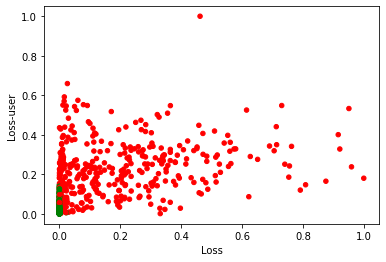

In [8]:
nextplot()
combined_df.plot.scatter(x='Loss', y='Loss-user', s=20, c=np.where(combined_df['anomaly']==0, 'g', 'r'))
plt.savefig("main-user", dpi=1200)
plt.show()

<Figure size 432x288 with 0 Axes>

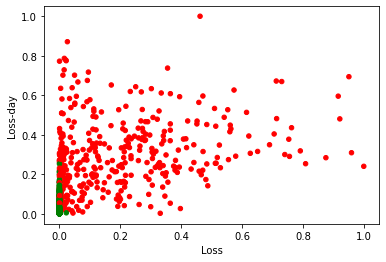

In [9]:
nextplot()
combined_df.plot.scatter(x='Loss', y='Loss-day', s=20, c=np.where(combined_df['anomaly']==0, 'g', 'r'))
plt.savefig("main-day", dpi=1200)

<Figure size 432x288 with 0 Axes>

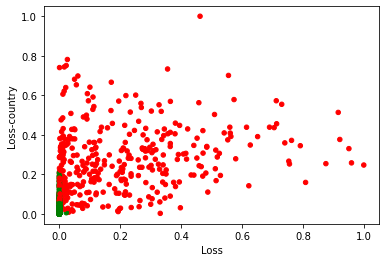

In [10]:
nextplot()
combined_df.plot.scatter(x='Loss', y='Loss-country', s=20, c=np.where(combined_df['anomaly']==0, 'g', 'r'))
plt.savefig("main-country", dpi=1200)

<Figure size 432x288 with 0 Axes>

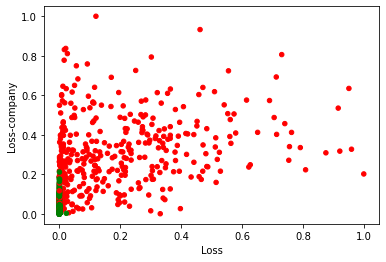

In [11]:
nextplot()
combined_df.plot.scatter(x='Loss', y='Loss-company', s=20, c=np.where(combined_df['anomaly']==0, 'g', 'r'))
plt.savefig("main-company", dpi=1200)

In [12]:
residual_csv=  combined_df.loc[combined_df['Loss'] < 0.0007]
print(len(residual_csv))

2630


<Figure size 432x288 with 0 Axes>

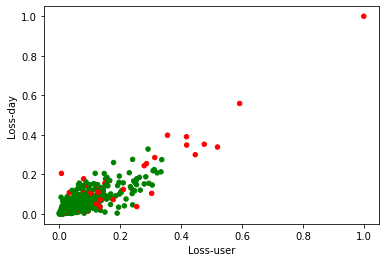

In [20]:
nextplot()
residual_csv.plot.scatter(x='Loss-user', y='Loss-day', s=20, c=np.where(residual_csv['anomaly']==0, 'g', 'r'))
plt.savefig("main-user-removed", dpi=1200)

<Figure size 432x288 with 0 Axes>

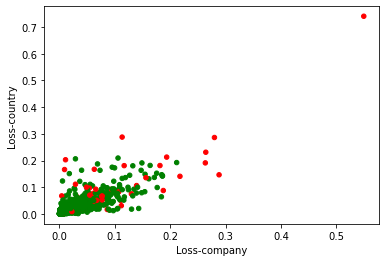

In [16]:
nextplot()
residual_csv.plot.scatter(x='Loss-company', y='Loss-country', s=20, c=np.where(residual_csv['anomaly']==0, 'g', 'r'))
plt.savefig("main-user-removed2", dpi=1200)

In [18]:
residual_csv['Loss-user'] = (residual_csv['Loss-user'] - residual_csv['Loss-user'].min()) / (residual_csv['Loss-user'].max() - residual_csv['Loss-user'].min())
residual_csv['Loss-day'] = (residual_csv['Loss-day'] - residual_csv['Loss-day'].min()) / (residual_csv['Loss-day'].max() - residual_csv['Loss-day'].min())
residual_csv['Loss-country'] = (residual_csv['Loss-country'] - residual_csv['Loss-country'].min()) / (residual_csv['Loss-country'].max() - residual_csv['Loss-country'].min())
residual_csv['Loss-company'] = (residual_csv['Loss-company'] - residual_csv['Loss-company'].min()) / (residual_csv['Loss-company'].max() - residual_csv['Loss-company'].min())
residual_csv['Loss'] = (residual_csv['Loss'] - residual_csv['Loss'].min()) / (residual_csv['Loss'].max() - residual_csv['Loss'].min())
residual_csv['att_avg'] = (residual_csv['Loss-user'] + residual_csv['Loss-day'] + residual_csv['Loss-country'] + residual_csv['Loss-company'])/4
residual_csv['att_max'] = residual_csv[['Loss-user','Loss-day','Loss-country','Loss-company']].max(axis=1)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_1176/152007652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residual_csv['Loss-user'] = (residual_csv['Loss-user'] - residual_csv['Loss-user'].min()) / (residual_csv['Loss-user'].max() - residual_csv['Loss-user'].min())
C:\Users\ASUS\AppData\Local\Temp/ipykernel_1176/152007652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residual_csv['Loss-day'] = (residual_csv['Loss-day'] - residual_csv['Loss-day'].min()) / (residual_csv['Loss-day'].max() - residual_

In [19]:
guess2 = residual_csv.loc[residual_csv['att_max'] > 0.39]
print(len(guess2))
print(np.sum(guess2['anomaly']))
guess2.head(10)

9
9


,case_id,Loss,Loss-user,Loss-day,Loss-country,Loss-company,label,anomaly,att_avg,att_max
171,12172,0.125141,0.278458,0.243896,0.190243,0.396017,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,0.277154,0.396017
193,12194,1.000000,0.592092,0.558853,0.386582,0.509334,"{'anomaly': 'Early', 'attr': {'shift_from': 9,...",1,0.511715,0.592092
281,12282,0.251872,0.519363,0.338422,0.287423,0.352370,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,0.374395,0.519363
447,12448,0.242702,0.475820,0.352600,0.388706,0.206056,"{'anomaly': 'Early', 'attr': {'shift_from': 3,...",1,0.355796,0.475820
760,12761,0.188253,0.418025,0.348338,0.258138,0.479392,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,0.375973,0.479392
1726,13727,0.545051,1.000000,1.000000,1.000000,1.000000,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,1.000000,1.000000
2206,14207,0.506867,0.355157,0.398146,0.244751,0.330335,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,0.332097,0.398146
2631,14632,0.557470,0.417615,0.390470,0.197869,0.524538,"{'anomaly': 'Late', 'attr': {'shift_from': 0, ...",1,0.382623,0.524538
2960,14961,0.178486,0.446332,0.299552,0.312105,0.480918,"{'anomaly': 'Attribute', 'attr': {'attribute':...",1,0.384726,0.480918
